In [1]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import sympy as sp
import xgboost as xgb
import torch, torch.nn as nn
import joblib

from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve
)

# your existing splitter
from data_processor import load_features_and_split3

ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True, parents=True)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
test_feat = ARTIFACTS / "features_test.parquet"
test_y    = ARTIFACTS / "y_test.parquet"

if test_feat.exists() and test_y.exists():
    X_test = pd.read_parquet(test_feat)
    y_test = pd.read_parquet(test_y)["y"].astype(int).values
    feat_names = list(X_test.columns)
    print("Loaded test split from artifacts/")
else:
    X_train, X_val, X_test, y_train, y_val, y_test = load_features_and_split3(
        "orbit_results_sobol_4.csv", test_size=0.20, val_size=0.10, random_state=SEED, stratify=True
    )
    y_test = y_test.values.astype(int)
    feat_names = list(X_test.columns)
    print("Recreated split (seeded).")


Recreated split (seeded).


In [3]:
def load_bdt(model_dir=ARTIFACTS):
    with open(model_dir / "bdt_meta.json") as f:
        meta = json.load(f)
    booster = xgb.Booster()
    booster.load_model(model_dir / meta["model_file"])
    return booster, meta

def predict_bdt(X: pd.DataFrame, booster: xgb.Booster, meta: dict) -> np.ndarray:
    X_use = X[meta["feature_names"]]
    dmat = xgb.DMatrix(X_use, feature_names=meta["feature_names"])
    best_iter = int(meta.get("best_iteration", 0))
    try:
        proba = booster.predict(dmat, iteration_range=(0, best_iter + 1))
    except TypeError:
        proba = booster.predict(dmat, ntree_limit=getattr(booster, "best_ntree_limit", best_iter + 1))
    return proba

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden=(128, 64), dropout=0.1):
        super().__init__()
        layers, prev = [], in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x).squeeze(-1)

import inspect

def load_mlp(model_dir=ARTIFACTS, device=torch.device("cpu")):
    with open(model_dir / "mlp_meta.json") as f:
        meta = json.load(f)

    # Safety: ensure the feature set matches what the model expects
    in_dim = len(meta["feature_names"])
    hidden = tuple(meta.get("hidden", [128, 64]))
    dropout = float(meta.get("dropout", 0.1))

    scaler = joblib.load(model_dir / meta["scaler_file"])
    model = MLP(in_dim, hidden=hidden, dropout=dropout)

    # Opt into safe loading if supported by your torch version
    load_kwargs = {"map_location": device}
    if "weights_only" in inspect.signature(torch.load).parameters:
        load_kwargs["weights_only"] = True

    state = torch.load(model_dir / meta["model_file"], **load_kwargs)

    # Allow architecture drift (e.g., older artifacts) but report it clearly
    incompatible = model.load_state_dict(state, strict=False)
    if incompatible.missing_keys or incompatible.unexpected_keys:
        print("load_state_dict notice:")
        if incompatible.missing_keys:
            print("  missing keys   :", incompatible.missing_keys)
        if incompatible.unexpected_keys:
            print("  unexpected keys:", incompatible.unexpected_keys)

    model.to(device).eval()
    return model, scaler, meta


@torch.no_grad()
def predict_mlp(X: pd.DataFrame, model: nn.Module, scaler, meta: dict, device=torch.device("cpu")) -> np.ndarray:
    X_use = X[meta["feature_names"]].values
    X_use = scaler.transform(X_use)
    BS = 512
    out = []
    for i in range(0, len(X_use), BS):
        xb = torch.from_numpy(X_use[i:i+BS]).float().to(device)
        proba = torch.sigmoid(model(xb)).cpu().numpy()
        out.append(proba)
    return np.concatenate(out)

# --- Symbolic Regressor (PySR) loader & predictor ---
def load_sr(model_dir=ARTIFACTS):
    
    with open(model_dir / "sr_pysr_meta.json") as f:
        meta = json.load(f)

    feat_names_sr = meta["feature_names"]
    n = len(feat_names_sr)
    xs = sp.symbols(" ".join([f"x{i}" for i in range(n)]))  # symbols x0..x{n-1}
    expr = sp.sympify(meta["equation"])
    fn = sp.lambdify(xs, expr, modules="numpy")             # vectorized numpy callable

    # Pretty print with named features (for log/report)
    subs = {sp.Symbol(f"x{i}"): sp.Symbol(feat_names_sr[i]) for i in range(n)}
    expr_named = expr.xreplace(subs)
    print("SR equation (named features):\n", sp.pretty(expr_named), "\n")

    return fn, meta

def predict_sr(X: pd.DataFrame, fn, meta: dict) -> np.ndarray:
    X_use = X[meta["feature_names"]].values
    logit = fn(*[X_use[:, j] for j in range(X_use.shape[1])])
    logit = np.asarray(logit, dtype=float)
    if meta.get("interpretation", "sigmoid") == "sigmoid":
        proba = 1.0 / (1.0 + np.exp(-logit))
    else:
        proba = np.clip(logit, 0.0, 1.0)
    return proba


In [4]:
# BDT
booster, bdt_meta = load_bdt()
proba_bdt = predict_bdt(X_test, booster, bdt_meta)
pred_bdt  = (proba_bdt >= float(bdt_meta.get("threshold", 0.5))).astype(int)

# MLP
model, scaler, mlp_meta = load_mlp(device=device)
proba_mlp = predict_mlp(X_test, model, scaler, mlp_meta, device=device)
pred_mlp  = (proba_mlp >= float(mlp_meta.get("threshold", 0.5))).astype(int)

# SR
sr_fn, sr_meta = load_sr()
proba_sr = predict_sr(X_test, sr_fn, sr_meta)
pred_sr  = (proba_sr >= float(sr_meta.get("threshold", 0.5))).astype(int)


load_state_dict notice:
  unexpected keys: ['net.1.x', 'net.1.y', 'net.4.x', 'net.4.y']
SR equation (named features):
                                   ⎛                                            ↪
3.7193508⋅mass + 3.7193508⋅v₀⋅tanh⎜(0.332552201467307⋅r₀ - 0.669956959285108⋅v ↪
                                  ⎝                                            ↪

↪    ⎛                                  v₀    ⎞⎞
↪ ₀)⋅⎜0.037296787⋅sin_dtheta + v₀ + ──────────⎟⎟
↪    ⎝                              cos_dtheta⎠⎠ 



In [5]:
# 1) Make sure you are opening the meta file you think you are
meta_path = ARTIFACTS / "mlp_meta.json"
print("Using meta:", meta_path.read_text()[:400])  # preview

# 2) Inspect the keys in the checkpoint vs your current model
state = torch.load(ARTIFACTS / json.loads(meta_path.read_text())["model_file"], map_location="cpu")
print("Checkpoint keys (first 12):", list(state.keys())[:12])

tmp_model = MLP(in_dim=len(json.loads(meta_path.read_text())["feature_names"]),
                hidden=tuple(json.loads(meta_path.read_text()).get("hidden",[128,64])),
                dropout=float(json.loads(meta_path.read_text()).get("dropout",0.1)))
print("Model keys (first 12):", list(tmp_model.state_dict().keys())[:12])



Using meta: {
  "framework": "pytorch",
  "model_file": "mlp_state.pt",
  "scaler_file": "mlp_scaler.joblib",
  "feature_names": [
    "r0",
    "v0",
    "cos_dtheta",
    "sin_dtheta",
    "mass",
    "rTarget"
  ],
  "hidden": [
    128,
    64
  ],
  "dropout": 0.1,
  "best_epoch": 121,
  "threshold": 0.5,
  "seed": 42,
  "pos_weight": 5.566604127579738
}
Checkpoint keys (first 12): ['net.0.weight', 'net.0.bias', 'net.1.x', 'net.1.y', 'net.3.weight', 'net.3.bias', 'net.4.x', 'net.4.y', 'net.6.weight', 'net.6.bias']
Model keys (first 12): ['net.0.weight', 'net.0.bias', 'net.3.weight', 'net.3.bias', 'net.6.weight', 'net.6.bias']


/tmp/ipykernel_10036/3529388234.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ARTIFACTS / json.loads(meta_path.read_text())["model_file"], map_locat

In [6]:
def summarize(y_true, proba, pred, name):
    return {
        "model": name,
        "roc_auc": float(roc_auc_score(y_true, proba)),
        "pr_auc": float(average_precision_score(y_true, proba)),
        "tp": int(((y_true==1) & (pred==1)).sum()),
        "fp": int(((y_true==0) & (pred==1)).sum()),
        "tn": int(((y_true==0) & (pred==0)).sum()),
        "fn": int(((y_true==1) & (pred==0)).sum()),
    }

metrics_bdt = summarize(y_test, proba_bdt, pred_bdt, "BDT")
metrics_mlp = summarize(y_test, proba_mlp, pred_mlp, "MLP")
metrics_sr  = summarize(y_test, proba_sr,  pred_sr,  "SR (symbolic)")

pd.DataFrame([metrics_bdt, metrics_mlp, metrics_sr]).sort_values("roc_auc", ascending=False)


,model,roc_auc,pr_auc,tp,fp,tn,fn
1,MLP,0.946754,0.696325,285,256,1440,19
2,SR (symbolic),0.944680,0.679054,285,295,1401,19
0,BDT,0.940483,0.674138,246,165,1531,58


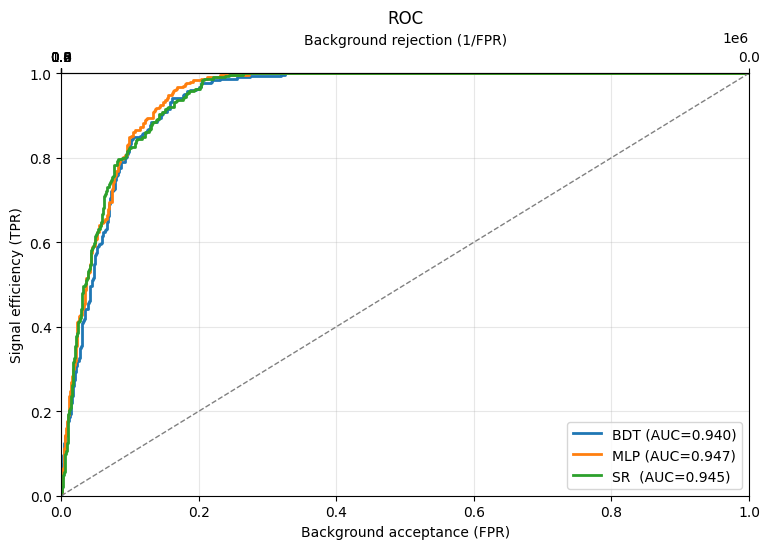

<Figure size 780x560 with 0 Axes>

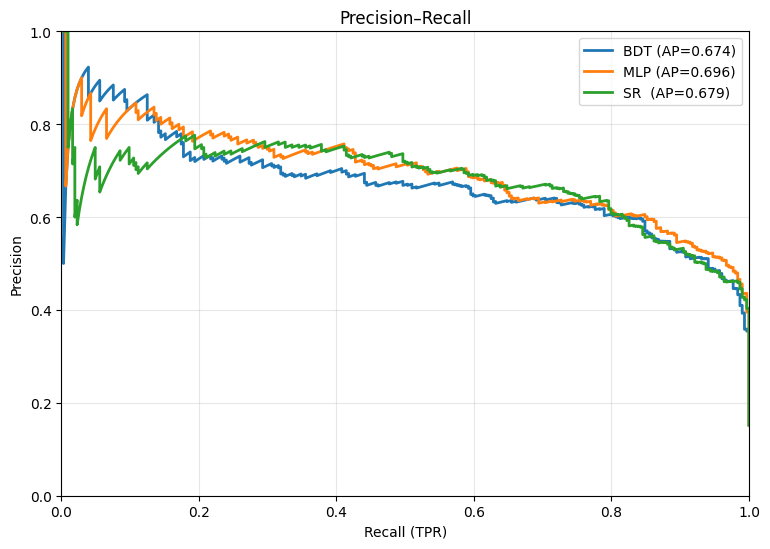

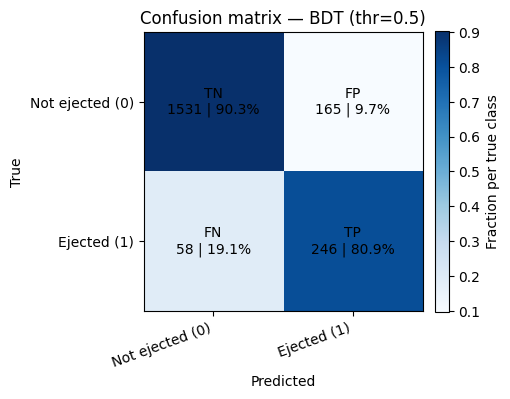

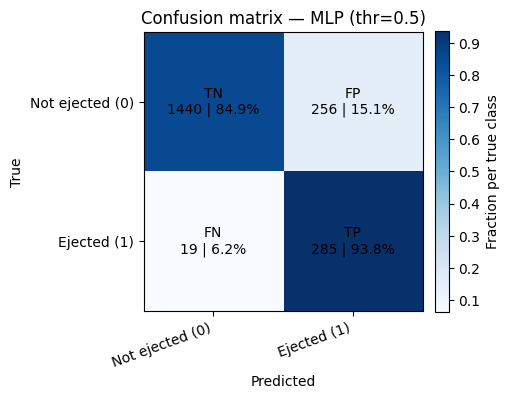

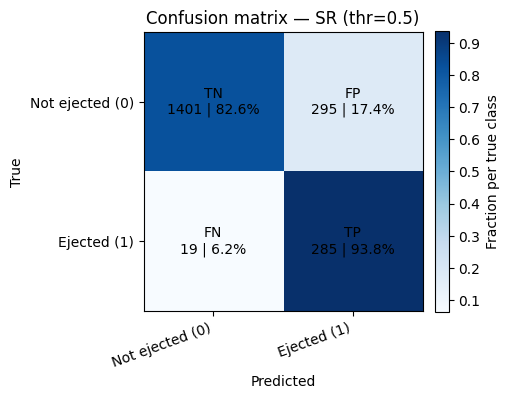

In [7]:
# ROC
fpr_bdt, tpr_bdt, _ = roc_curve(y_test, proba_bdt)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, proba_mlp)
fpr_sr,  tpr_sr,  _ = roc_curve(y_test, proba_sr)

plt.figure(figsize=(7.8,5.6))
plt.plot(fpr_bdt, tpr_bdt, lw=2, label=f"BDT (AUC={metrics_bdt['roc_auc']:.3f})")
plt.plot(fpr_mlp, tpr_mlp, lw=2, label=f"MLP (AUC={metrics_mlp['roc_auc']:.3f})")
plt.plot(fpr_sr,  tpr_sr,  lw=2, label=f"SR  (AUC={metrics_sr['roc_auc']:.3f})")
plt.plot([0,1],[0,1],'--',lw=1,color='gray')
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Background acceptance (FPR)")
plt.ylabel("Signal efficiency (TPR)")
plt.title("ROC")

def fwd(f): f=np.clip(np.array(f),1e-6,1.0); return 1.0/f
def inv(r): r=np.clip(np.array(r),1.0,1e6);  return 1.0/r
plt.gca().secondary_xaxis('top', functions=(fwd, inv)).set_xlabel("Background rejection (1/FPR)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# PR
prec_bdt, rec_bdt, _ = precision_recall_curve(y_test, proba_bdt)
prec_mlp, rec_mlp, _ = precision_recall_curve(y_test, proba_mlp)
prec_sr,  rec_sr,  _ = precision_recall_curve(y_test, proba_sr)

plt.figure(figsize=(7.8,5.6))
plt.plot(rec_bdt, rec_bdt*0 + np.nan)  # avoid accidental var reuse
plt.clf()
plt.figure(figsize=(7.8,5.6))
plt.plot(rec_bdt, prec_bdt, lw=2, label=f"BDT (AP={metrics_bdt['pr_auc']:.3f})")
plt.plot(rec_mlp, prec_mlp, lw=2, label=f"MLP (AP={metrics_mlp['pr_auc']:.3f})")
plt.plot(rec_sr,  prec_sr,  lw=2, label=f"SR  (AP={metrics_sr['pr_auc']:.3f})")
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Recall (TPR)"); plt.ylabel("Precision")
plt.title("Precision–Recall")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


def plot_cmatrix(y_true, pred, title):
    cm  = confusion_matrix(y_true, pred)
    cmn = cm / cm.sum(axis=1, keepdims=True)
    labels = np.array([["TN","FP"],["FN","TP"]])
    classes = ["Not ejected (0)", "Ejected (1)"]
    fig, ax = plt.subplots(figsize=(5.2,4.8))
    im = ax.imshow(cmn, cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0,1], labels=classes, rotation=20, ha="right")
    ax.set_yticks([0,1], labels=classes)
    for (i,j), v in np.ndenumerate(cmn):
        ax.text(j,i,f"{labels[i,j]}\n{cm[i,j]} | {v*100:.1f}%", ha="center", va="center", fontsize=10)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Fraction per true class")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); plt.tight_layout()
    return fig

plot_cmatrix(y_test, pred_bdt, "Confusion matrix — BDT (thr=0.5)")
plot_cmatrix(y_test, pred_mlp, "Confusion matrix — MLP (thr=0.5)")
plot_cmatrix(y_test, pred_sr, "Confusion matrix — SR (thr=0.5)")

plt.show()


In [8]:
compare = {
    "bdt": metrics_bdt | {"threshold": float(bdt_meta.get("threshold", 0.5))},
    "mlp": metrics_mlp | {"threshold": float(mlp_meta.get("threshold", 0.5))},
    "sr":  metrics_sr  | {"threshold": float(sr_meta.get("threshold", 0.5)),
                          "equation": sr_meta.get("equation", ""),
                          "feature_names": sr_meta.get("feature_names", [])}
}
with open(ARTIFACTS / "compare_metrics.json", "w") as f:
    json.dump(compare, f, indent=2)
print("Wrote artifacts/compare_metrics.json")


Wrote artifacts/compare_metrics.json
